# Speech EndPoint Detector

In [69]:
!pip install librosa
!pip install matplotlib
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

# The Short-Time Energy, En (DEF)

In [70]:
def short_time_energy(signal, window_size, hop_length):
    framesE = librosa.util.frame(signal, frame_length=window_size, hop_length=hop_length)
    energy = np.sum(framesE**2, axis=0)
    return energy

# The Short-Time Magnitude, Mn (DEF)


In [71]:
def short_time_magnitude(signal,window_size,hop_length):
    framesM = librosa.util.frame(signal, frame_length=window_size, hop_length=hop_length)
    magnitude = np.mean(np.abs(framesM), axis=0)
    return magnitude


# The Short-Time Zero-Crossing, Zn (DEF)
 

In [72]:
def short_time_zero_crossing(signal,window_size,hop_length):
    framesZ = librosa.util.frame(signal, frame_length=window_size, hop_length=hop_length)
    zero_crossings = np.sum(np.diff(np.sign(framesZ), axis=0) != 0, axis=0)
    return zero_crossings

# Speech Start - Energy and Silence Thresholds


In [73]:
def speech_start_energy_and_silence_thresholds(energy, threshold_energy):
    speech_start = 0
    for i in range(len(energy)):
        if energy[i] > threshold_energy:
            speech_start = i
            break
    return speech_start

# Speech End - Energy and Silence Thresholds


In [74]:
def speech_end_energy_and_silence_thresholds(energy, threshold_energy):
    speech_end = len(energy) - 1
    for i in range(len(energy) - 1, -1, -1):
        if energy[i] > threshold_energy:
            speech_end = i
            break
    return speech_end

# Silence Threshold to Further Refine Speech Endpoints

In [75]:
def silence_threshold_to_further_refine(threshold_silence, sr, speech_start, speech_end, energy):
    silence_duration = int(threshold_silence * sr)
    for i in range(speech_start, speech_end):
        if energy[i] < threshold_energy and i - speech_start > silence_duration:
            speech_start = i
            break

    for i in range(speech_end, speech_start, -1):
        if energy[i] < threshold_energy and speech_end - i > silence_duration:
            speech_end = i
            break 
    return (speech_start,speech_end)       

 # Convert Sample Indices to Time In Seconds


In [76]:
def convert_to_sec_in_time(speech_start, speech_end, sr):
    speech_start_time = speech_start * hop_length / sr
    speech_end_time = speech_end * hop_length / sr
    return (speech_start_time, speech_end_time)

# Perform VAD

In [77]:
def perform_VAD(speech_start_time, speech_end_time, signal, sr):  
    vad = np.zeros_like(signal)
    vad[int(speech_start_time * sr):int(speech_end_time * sr)] = 1
    return vad

# Time Axis

In [78]:
def time_axis(frames, hop_length, sr):
    t_frames = librosa.frames_to_time(np.arange(len(frames)), sr=sr, hop_length=hop_length)
    return t_frames

# Plotting the Time-Energy, Magnitude, Zero-Crossing and VAD

In [79]:
def _plot(signal, energy, magnitude, zero_crossing, vad, sr, hop_length):
    # Plotting the time-energy, magnitude, zero-crossing rate, and VAD results
    time = np.arange(len(signal)) / sr
    t_framesE = time_axis(energy, hop_length, sr)
    t_framesM = time_axis(magnitude, hop_length, sr)
    t_framesZ = time_axis(zero_crossing, hop_length, sr)
    t_framesV = time_axis(vad, hop_length, sr)

    plt.figure(figsize=(10, 16))

    plt.subplot(5, 1, 1)
    plt.plot(np.arange(len(signal)) / sr, signal)
    plt.title("Speech Waveform")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    
    plt.subplot(5, 1, 2)
    plt.plot(t_framesV, vad, label ='Voice Activity Estimate', color='m')
    plt.xlabel('Time (s)')
    plt.ylabel('VAD')
    plt.title('Voice Activity Detection')

    plt.subplot(5, 1, 3)
    plt.plot(t_framesE, energy, label='Energy')
    plt.title("Short-Time Energy")
    plt.xlabel("Time")
    plt.ylabel("Energy")
    plt.legend()

    plt.subplot(5, 1, 4)
    plt.plot(t_framesM, magnitude, label='Magnitude')
    plt.title("Short-Time Magnitude")
    plt.xlabel("Time")
    plt.ylabel("Magnitude")
    plt.legend()

    plt.subplot(5, 1, 5)
    plt.plot(t_framesZ, zero_crossing, label='Zero Crossings', color='r')
    plt.title("Short-Time Zero Crossings")
    plt.xlabel("Time")
    plt.ylabel("Zero Crossings")
    plt.legend()


    plt.tight_layout()
    plt.show()

# Speech EndPoint Detector (DEF)

In [129]:
def speech_endpoint_detector(audio_file, signal, sr, threshold_energy, threshold_silence, window_size, hop_length):
    #Calculate the short-time energy of the audio signal
    energy = short_time_energy(signal, window_size, hop_length)
    #Calculate the short-time magnitude of the audio signal
    magnitude = short_time_magnitude(signal, window_size, hop_length)
    #Calculate the short-time zero-crossing
    zero_crossing = short_time_zero_crossing(signal, window_size, hop_length)
    # Normalize the energy values between 0 and 1
    energy = (energy - np.min(energy)) / (np.max(energy) - np.min(energy))
    # Determine speech start based on energy and silence thresholds
    speech_start = speech_start_energy_and_silence_thresholds(energy, threshold_energy)
    # Determine speech end based on energy and silence thresholds
    speech_end = speech_end_energy_and_silence_thresholds(energy, threshold_energy)
    # Apply silence threshold to further refine speech endpoints
    silence = silence_threshold_to_further_refine(threshold_silence, sr, speech_start, speech_end, energy)
    # Convert sample indices to time in seconds
    time_in_seconds = convert_to_sec_in_time(silence[0], silence[1], sr)
    # Perform VAD
    vad = perform_VAD(time_in_seconds[0], time_in_seconds[1], signal, sr)
    #Print the start and end times of the speech
    print(f"Speech detected from {time_in_seconds[0]:.2f} seconds (Starting Time)\n")
    print(f"Speech ended from {time_in_seconds[1]:.2f} seconds (Ending Time)\n")
    #Plot
    _plot(signal, energy, magnitude, zero_crossing, vad, sr, hop_length )
    


# Load speech waveform from file

In [130]:
#read the audio
audio_file = 's5.wav'
#Load the audio file
signal, sr = librosa.load(audio_file, sr = None) 

In [131]:
# Define Analysis Parameters

In [132]:
window_size = int(0.02 * sr)  # 20ms window size
hop_length = int(0.01 * sr)  # 10ms hop length
threshold_energy = 0.1  # 0.1 threshold energy
threshold_silence=0.3  # 0.5 threshold silence 

Speech detected from 0.16 seconds (Starting Time)

Speech ended from 2.28 seconds (Ending Time)



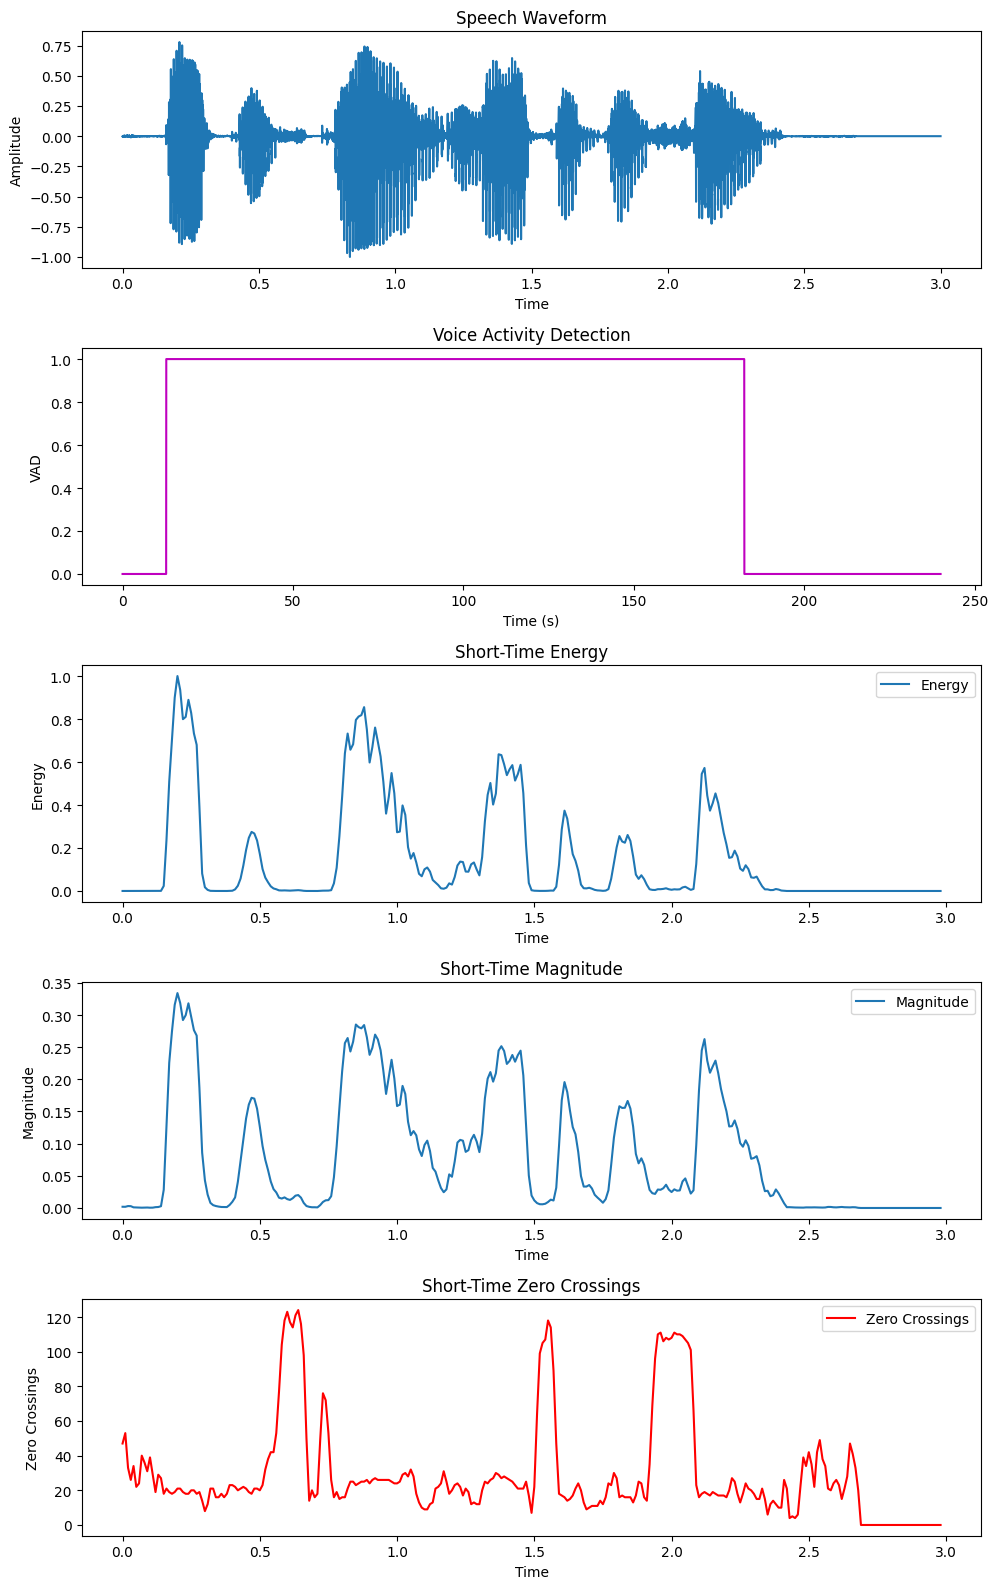

In [133]:
speech_endpoint_detector(audio_file, signal, sr, threshold_energy, threshold_silence, window_size, hop_length)